# Análisis y Predicción de la Deserción de Empleados (IBM HR Analytics)
## 1. Introducción

En este proyecto se analiza la rotación de personal en IBM, identificando los factores clave que influyen en la decisión de los empleados de abandonar la compañía. Se examinan los perfiles de los empleados que se van, con el objetivo de comprender los determinantes más relevantes de la rotación laboral. Posteriormente, se desarrollan y evalúan modelos de machine learning basados en algoritmos de clasificación binaria, con el fin de proporcionar herramientas predictivas al departamento de recursos humanos que permitan anticipar posibles deserciones y diseñar estrategias para retener talento valioso.


## 2. Flujo de trabajo
  * Exploración inicial y limpieza de datos
      
  * Análisis exploratorio (EDA)  
     
  * Modelado predictivo y evaluación
     
  * Conclusiones y recomendaciones


## 3. Librerías y carga de datos

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline # Maneja muestras aumentadas con smote
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score,average_precision_score,confusion_matrix,precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate,GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

## 4. Exploración inicial y limpieza de datos

In [2]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [3]:
print(f'El conjunto de datos presenta {df.shape[1]} columnas o variables y {df.shape[0]} registros.')

El conjunto de datos presenta 35 columnas o variables y 1470 registros.


El conjunto de datos presenta 35 columnas o variables y 1470 registros.

In [4]:
# Vista parcial del conjunto de datos
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


In [5]:
# Columnas con valores nulos en el conjunto de datos
nulos = df.isnull().any(axis=1).sum()
print(f'Número de registros con valores nulos en la base de datos: {nulos}')

Número de registros con valores nulos en la base de datos: 0


In [6]:
duplicados = df.duplicated().sum()
print(f'Número de registros duplicados en la base de datos: {duplicados}')

Número de registros duplicados en la base de datos: 0


#### Identificación de columnas uméricas y categóricas:

In [7]:
# Variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print(f'Variables categóricas en la base de datos: {cat_cols.values}')

Variables categóricas en la base de datos: ['Attrition' 'BusinessTravel' 'Department' 'EducationField' 'Gender'
 'JobRole' 'MaritalStatus' 'Over18' 'OverTime']


In [8]:
# Variables numéricas
num_cols = df.select_dtypes(include=['int64']).columns
print(f'Variables numéricas en la base de datos: {num_cols.values}')

Variables numéricas en la base de datos: ['Age' 'DailyRate' 'DistanceFromHome' 'Education' 'EmployeeCount'
 'EmployeeNumber' 'EnvironmentSatisfaction' 'HourlyRate' 'JobInvolvement'
 'JobLevel' 'JobSatisfaction' 'MonthlyIncome' 'MonthlyRate'
 'NumCompaniesWorked' 'PercentSalaryHike' 'PerformanceRating'
 'RelationshipSatisfaction' 'StandardHours' 'StockOptionLevel'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'WorkLifeBalance'
 'YearsAtCompany' 'YearsInCurrentRole' 'YearsSinceLastPromotion'
 'YearsWithCurrManager']


In [9]:
# Variables con un solo valor 
for column in df.columns:
    if df[column].nunique() < 2:
        print(f'{column} : {df[column].nunique()}: {df[column].unique()}')

EmployeeCount : 1: [1]
Over18 : 1: ['Y']
StandardHours : 1: [80]


## 5. Análisis exploratorio de Datos(EDA)

Para comprender y conocer los factores claves que inciden en la rotación de empleados de la compañía se realiza un análisis exploratorío de los datos:

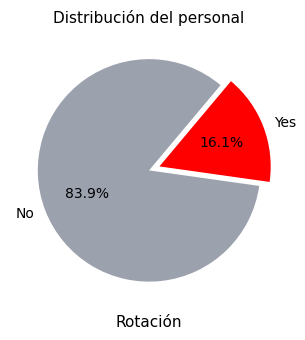

In [10]:
# Distribución de personal en la base de datos 
plt.figure(figsize=(4,3.5))
df.Attrition.value_counts(normalize=True).mul(100).round(2).plot(kind='pie', startangle=50,  explode=[0, 0.1], autopct='%1.1f%%',colors=['#9CA1AE', 'red'])
plt.title('Distribución del personal', fontsize=11)
plt.xlabel('Rotación', fontsize=11)
plt.ylabel('') 
plt.tight_layout()
plt.show()


El 16.1% del personal en la base de datos de RR HH de IBM, ha desertado de la compañia.

El análisis de la tasa de rotación desagregada por características del empleado y contexto laboral se realiza empleando la función `plot_rotation` definida para graficar el perfil de cada variable respecto de a rotación y generar una tabla resumen con el número de empleados y la tasa de rotación en cada categoría. 

In [11]:
#Resumen y gráfica de la tasa de rotación, fuerza laboral vs rotación
sns.set_context("notebook", font_scale=0.8)

def plot_rotacion(df, columna, figsize=(9,5), rotation=0, ha='center', show_table=True):
    resumen = (
        df.groupby(columna)['Attrition']
          .value_counts()
          .unstack(fill_value=0)
          .assign(total=lambda d: d.sum(axis=1))
          .assign(rot_rate=lambda d: d['Yes'] / d['total'] * 100)
          .reset_index()
    )

    resumen = resumen.sort_values(by=columna).reset_index(drop=True)
    x = np.arange(len(resumen))  
    etiquetas = resumen[columna].astype(str)

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.bar(x, resumen['total'], color='#9CA1AE', width=0.4)
    ax1.set_ylabel('Total empleados', color='#9CA1AE')
    ax1.set_xlabel(columna)
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(x, resumen['rot_rate'], color='red', marker='o', linewidth=1)
    ax2.set_ylabel('Tasa de rotación (%)', color='red')
    ax2.grid(False)

    ax1.set_xticks(x)
    ax1.set_xticklabels(etiquetas, rotation=rotation, ha=ha)

    plt.title(f'Fuerza laboral total vs. tasa de rotación por {columna}')
    plt.tight_layout()
    plt.show()

    resumen_tabla = resumen[[columna, 'total','Yes' ,'rot_rate']].copy()
    resumen_tabla.columns = [columna, 'Total empleados','Rotación', 'Tasa de rotación (%)']
    
    if show_table:
        display(
            resumen_tabla.sort_values(by='Tasa de rotación (%)', ascending=False).style.format({'Tasa de rotación (%)': '{:.2f}'}).
            background_gradient(subset=['Tasa de rotación (%)'], cmap='Reds')
            .hide(axis="index")
            .set_caption(f"Resumen de rotación por {columna}")
    )

### 2.1 Demografía

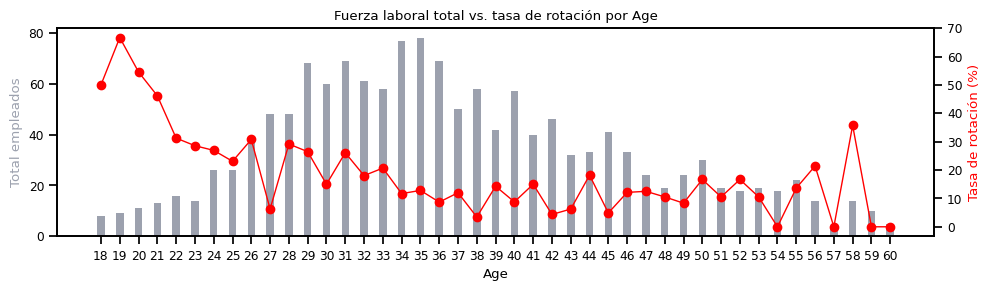

In [12]:
#Edad
plot_rotacion(df,'Age', figsize=(10,3), show_table=False)

Empleados jovenes con edades inferiores a los 30 años presentan las tasas de rotación más elevadas, 9 de 10 posiciones en el top10 corresponden a empleados entre 19 y 28 años con tasas de rotación entre 26.9 y 66.66 %. La alta tasa de rotación en empleados de la tercera edad (35.71%) se atribuye a su cercania con la edad de jubilación.

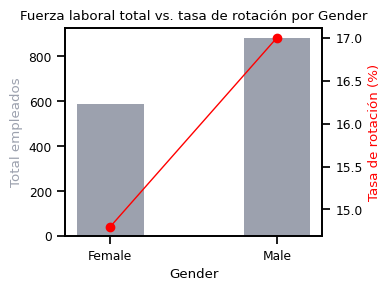

Gender,Total empleados,Rotación,Tasa de rotación (%)
Male,882,150,17.01
Female,588,87,14.80


In [13]:
#Genero
plot_rotacion(df, 'Gender', figsize=(4,3))

La tasa de rotación más elevada (17.01%) se presenta en el personal de sexo masculino.

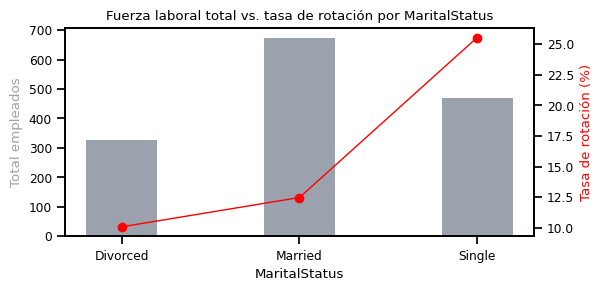

MaritalStatus,Total empleados,Rotación,Tasa de rotación (%)
Single,470,120,25.53
Married,673,84,12.48
Divorced,327,33,10.09


In [14]:
#Estatus marital
plot_rotacion(df, 'MaritalStatus', figsize=(6,3))

El personal soltero presenta la tasa de rotación más elevada (25,53%)y duplica la tasa de casados (12,48) o divorciados (10,09).

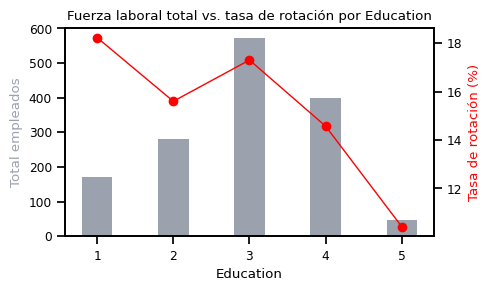

Education,Total empleados,Rotación,Tasa de rotación (%)
1,170,31,18.24
3,572,99,17.31
2,282,44,15.60
4,398,58,14.57
5,48,5,10.42


In [15]:
# Nivel educativo - Education: 1 'Below College', 2 'College', 3 'Bachelor', 4 'Master', 5 'Doctor'
plot_rotacion(df, 'Education', figsize=(5,3))

En general la tasa de rotación de personal de todos los niveles de formación educativa a excepción del Doctorado, presentan un comportaminento similar con tasas entre 14 y 18% con diferencias inferiores a dos puntos porcentuales. El personal con titulo de Doctor, presenta la tasa de rotación más baja con el 10,42%.

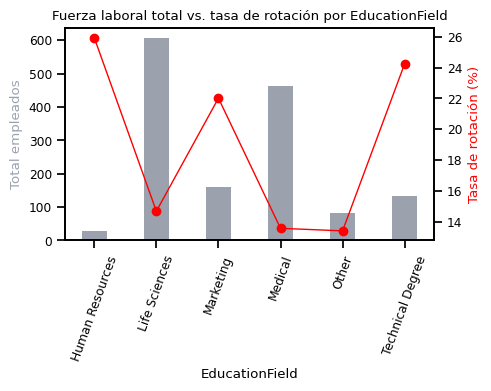

EducationField,Total empleados,Rotación,Tasa de rotación (%)
Human Resources,27,7,25.93
Technical Degree,132,32,24.24
Marketing,159,35,22.01
Life Sciences,606,89,14.69
Medical,464,63,13.58
Other,82,11,13.41


In [16]:
plot_rotacion(df, 'EducationField', figsize=(5,4), rotation=70)

Si bien la mayoría de los empleados que abandonaron la compañía registran formación en ciencias de la vida o medicina, el análisis proporcional indica que el personal con estudios en recursos humanos, marketing o educación técnica presenta las tasas de rotación más elevadas con valores superiores al 20%.

### 2.2 Departamento y/o condiciones laborales

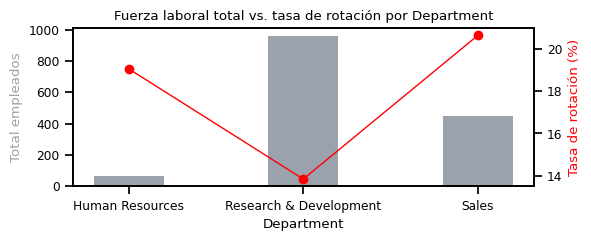

Department,Total empleados,Rotación,Tasa de rotación (%)
Sales,446,92,20.63
Human Resources,63,12,19.05
Research & Development,961,133,13.84


In [17]:
plot_rotacion(df, 'Department', figsize=(6,2.5))

Aunque la mayoría absoluta de los empleados que abandonaron pertenecen a Investigación y Desarrollo (I+D),
la tasa de rotación deL departamento DE I+D es la más baja entre las tres áreas. El análisis proporcional muestra que la tasa de rotación (13.8 %) es menor que la de Ventas (20.6 %) y Recursos Humanos (19 %).

El mayor número de abandonos en Investigación y Desarrollo se explica por el tamaño del departamento, no por una mayor propensión individual al abandono.

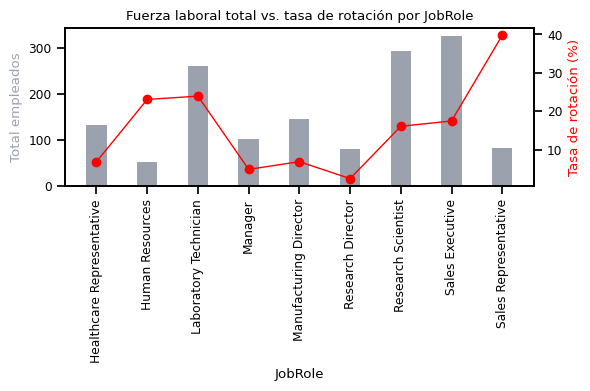

JobRole,Total empleados,Rotación,Tasa de rotación (%)
Sales Representative,83,33,39.76
Laboratory Technician,259,62,23.94
Human Resources,52,12,23.08
Sales Executive,326,57,17.48
Research Scientist,292,47,16.10
Manufacturing Director,145,10,6.90
Healthcare Representative,131,9,6.87
Manager,102,5,4.90
Research Director,80,2,2.50


In [18]:
plot_rotacion(df, 'JobRole', figsize=(6,4), rotation=90)

Roles como representantes de ventas, técnicos de laboratorio y recursos humanos presentan tasas de rotación altas con valores entre 23 y 39%. Ejecutivos de ventas y cientificos investigadores presentan tasas de rotación moderadas entre 16 -18%.

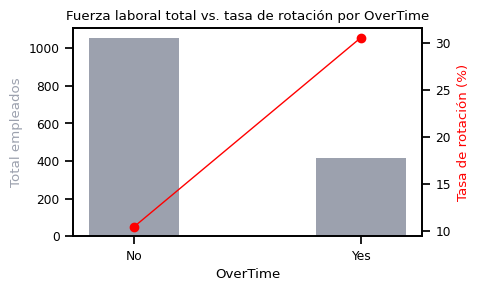

OverTime,Total empleados,Rotación,Tasa de rotación (%)
Yes,416,127,30.53
No,1054,110,10.44


In [19]:
# Horas extras
plot_rotacion(df, 'OverTime', figsize=(5,3))

La tasa de rotación de aquellos quienes trabajan horas extras es de 30.53% en comparación con la tasa de 10.44% de quienes trabajan en su horario habitual. Laborar horas extras influye negativamente en la decisión del personal de abandonar la compañía. 

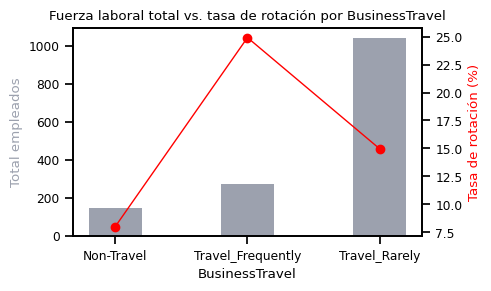

BusinessTravel,Total empleados,Rotación,Tasa de rotación (%)
Travel_Frequently,277,69,24.91
Travel_Rarely,1043,156,14.96
Non-Travel,150,12,8.00


In [20]:
# Viajes de negocios
plot_rotacion(df, 'BusinessTravel', figsize=(5,3))

Quienes deben hacer viajes de trabajo con frecuencia presenta una tasa de rotación alta de 24.91%, en comparación con quienes raramente viajan (14.96%) o nunca lo hacen (8%).

### 2.3 Desempeño y/o Satisfacción

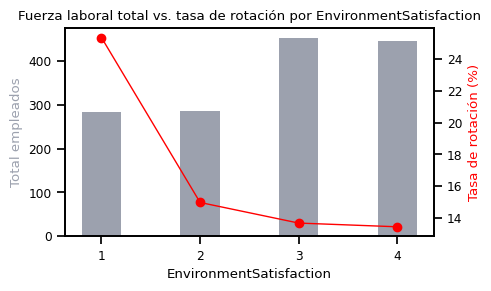

EnvironmentSatisfaction,Total empleados,Rotación,Tasa de rotación (%)
1,284,72,25.35
2,287,43,14.98
3,453,62,13.69
4,446,60,13.45


In [21]:
# Satisfacción ambiental - EnvironmentSatisfaction: 1 'Low', 2 'Medium', 3 'High', 4 'Very High'
plot_rotacion(df, 'EnvironmentSatisfaction', figsize=(5,3))

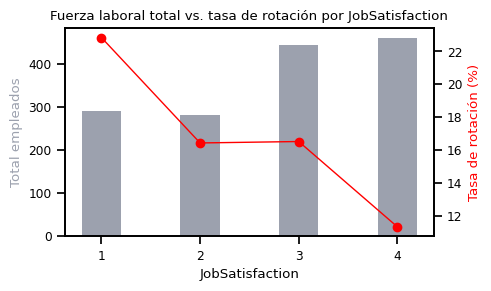

JobSatisfaction,Total empleados,Rotación,Tasa de rotación (%)
1,289,66,22.84
3,442,73,16.52
2,280,46,16.43
4,459,52,11.33


In [22]:
#Satisfación Laboral
plot_rotacion(df, 'JobSatisfaction', figsize=(5,3))

El análisis proporcional muestra tasas de rotación superiores al 22% para registros de satisfacción laboral o ambiental bajas (1). El incremento en la satisfacción laboral y ambiental favorecen la retención de personal, quien registra baja satisfacción es más propenso a abandonar su empleo. 

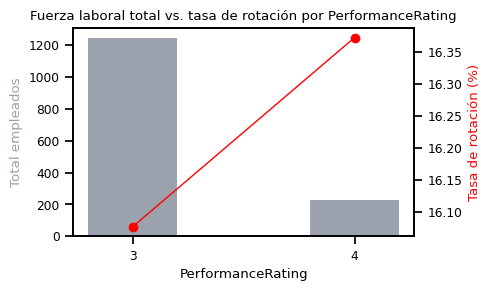

PerformanceRating,Total empleados,Rotación,Tasa de rotación (%)
4,226,37,16.37
3,1244,200,16.08


In [23]:
# Calificación de desempeño - PerformanceRating: 1 'Low', 2 'Good',3 'Excellent', 4 'Outstanding'
plot_rotacion(df, 'PerformanceRating', figsize=(5,3))

Las tasas de rotación para empleados con desempeño excelente o sobresaliente son similares ( 16.08 y 16.37%). En este conjunto de datos, la evaluación de desempeño de la compañía solo utiliza los niveles 3 y 4, correspondientes a “Excelente” y “Sobresaliente”, por lo que la categoría “Excelente” parece ser la calificación estándar para la mayoría de los empleados. La evaluación de desempeño del personal no incide en la decisión del empleado de abandonar la compañia.

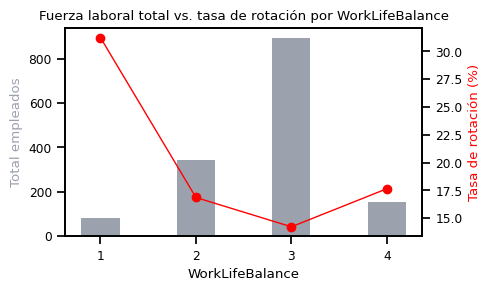

WorkLifeBalance,Total empleados,Rotación,Tasa de rotación (%)
1,80,25,31.25
4,153,27,17.65
2,344,58,16.86
3,893,127,14.22


In [24]:
# Equilibrio entre vida laboral y personal - WorkLifeBalance: 1 'Bad', 2 'Good', 3 'Better', 4 'Best'
plot_rotacion(df, 'WorkLifeBalance', figsize=(5,3))

El balance entre la vida personal y laboral es un factor crucial para la retención de empleados, aunque no es garantía de que el empleado desee permanecer en la compañia. El análisis proporcional muestra que aquellos quienes tiene un mal balance entre su vida personal y laboral presentan tasas de rotación elevadas (31.25%) frente a quienes han logrado equilibrar en cierta medida las cargas entre estos dos aspectos (<17.65%).

### 2.4 Antigüedad 

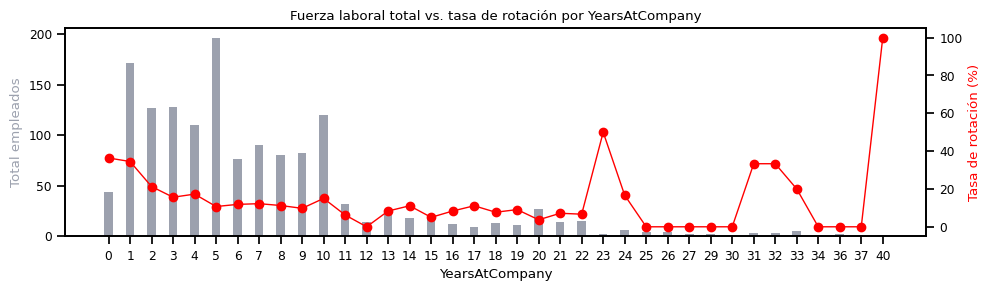

In [25]:
#Número de años en la compañía
plot_rotacion(df,'YearsAtCompany', figsize=(10,3), show_table=False)

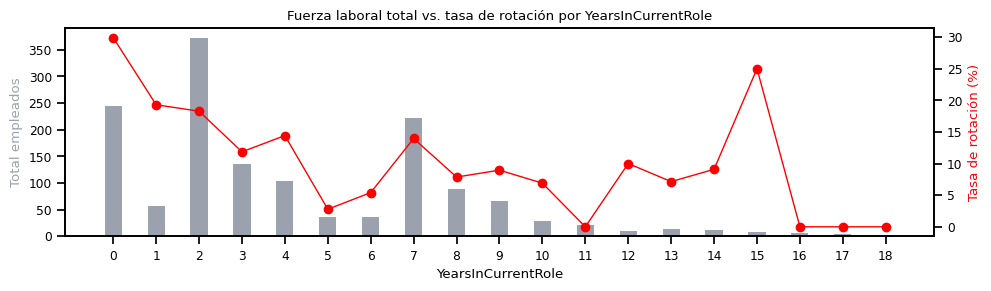

In [26]:
#Número de años en el role actual
plot_rotacion(df,'YearsInCurrentRole', figsize=(10,3), show_table=False)

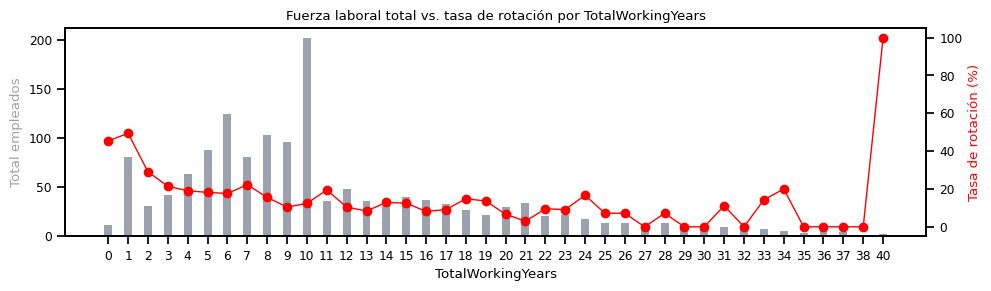

In [27]:
#Años de experiencia laboral
plot_rotacion(df,'TotalWorkingYears', figsize=(10,3), show_table=False)

En relación con la antigüedad de los empleados en la compañía, se observa que el personal con vinculación reciente o con pocos años desempeñando su rol actual presenta la mayor tasa de rotación. A medida que transcurre el tiempo, la tasa tiende a estabilizarse, aunque vuelve a incrementarse posteriormente, posiblemente debido a una menor satisfacción laboral o a la búsqueda de nuevos retos profesionales. Al analizar la experiencia laboral total, se identifica un patrón similar: los empleados con menor experiencia son más propensos a abandonar la organización.

### Perfil de empleados con mayor rotación
En general, el análisis del perfil de los empleados que han abandonado la compañía sugiere que la mayor rotación de personal se presenta en profesionales jovenes, solteros con formación universitaria o de posgrado, especialmente aquellos con roles relacionados con la investigación o las ventas, pertenecen al departamento de I+D y en ejercicio de sus funciones trabajan horas extras. 

No obstante, al contrastar estos resultados con la composición global de la fuerza laboral, se observa que el área de  I+D, aunque concentra el mayor número absoluto de abandonos, también reúne la mayor proporción de empleados dentro de la organización y su tasa de rotación relativa (13.8%) es menor que la observada en áreas como Ventas (20.6%) o Recursos Humanos (19%). Por lo tanto, las acciones de retención deberían enfocarse especialmente en los equipos comerciales y de recursos humanos, donde la probabilidad de rotación es significativamente mayor.

### 2.5 Correlación entre variables

Para profundizar en los factores que influyen en la rotación de personal, se realiza un análisis de correlación entre variables numéricas y categóricas con la variable objetivo ('Attrition'), con el fin de evaluar la dirección y fuerza de las relaciones.

#### 2.5.1 Numéricas

In [28]:
# Correlación entre las variables numéricas del set de datos y la variable objetivo 'Attrition'
att_encoded = pd.Series(pd.factorize(df['Attrition'])[0], name='Attrition_encoded')
corr_attr = df[num_cols].corrwith(att_encoded)
corr_attr =  corr_attr.sort_values(ascending=False).round(3)
print('=== Correlación entre variables numéricas y la variable objetivo ===')
print(corr_attr)

=== Correlación entre variables numéricas y la variable objetivo ===
TotalWorkingYears           0.171
JobLevel                    0.169
YearsInCurrentRole          0.161
MonthlyIncome               0.160
Age                         0.159
YearsWithCurrManager        0.156
StockOptionLevel            0.137
YearsAtCompany              0.134
JobInvolvement              0.130
JobSatisfaction             0.103
EnvironmentSatisfaction     0.103
WorkLifeBalance             0.064
TrainingTimesLastYear       0.059
DailyRate                   0.057
RelationshipSatisfaction    0.046
YearsSinceLastPromotion     0.033
Education                   0.031
PercentSalaryHike           0.013
EmployeeNumber              0.011
HourlyRate                  0.007
PerformanceRating          -0.003
MonthlyRate                -0.015
NumCompaniesWorked         -0.043
DistanceFromHome           -0.078
EmployeeCount                 NaN
StandardHours                 NaN
dtype: float64


En este conjunto de datos, todas las correlaciones son bastante bajas, lo que sugiere que la rotación de personal no está fuertemente correlacionada con ninguna variable numérica individualmente y en consecuencia, la probabilidad de abandono depende de múltiples factores combinados.

#### 2.5.2 Categóricas
Se emplea el estadistico V de Cramer para medir la fuerza de la asociación entre variables categóricas y la variable objetivo: 

In [29]:
# Correlción entre variables categóricas y variable objetivo mediante la  medición de la fuerza de asociación entre variables usando Cramér’s V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [30]:
# Variable objetivo
target = 'Attrition'

# Cálculo de la correlación de 'Attrition' con cada variable categórica
cramers_results = {col: cramers_v(df[col], df[target]) for col in cat_cols if col != target}

# Creación del DataFrame con la correlación de variables categóricas y Attrition 
cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['CramersV'])
cramers_df = cramers_df.sort_values(by='CramersV', ascending=False)
print('=== Correlación entre variables categóricas y la variable objetivo ===')
print(cramers_df.round(3))

=== Correlación entre variables categóricas y la variable objetivo ===
                CramersV
OverTime           0.243
JobRole            0.231
MaritalStatus      0.173
BusinessTravel     0.123
EducationField     0.087
Department         0.077
Gender             0.009
Over18               NaN


Según los resultados, las variables categóricas más relevantes para explicar la rotación de empleados son **OverTime**, **JobRole** y **MaritalStatus**, mientras que factores como género o departamento tienen menor impacto directo. Esto sugiere que la decisión de abandonar la compañía depende más de condiciones laborales y del rol específico del empleado que de características demográficas u organizacionales. 

## 6.  Modelado predictivo

Para el análisis de rotación de personal se entrenarán varios modelos de clasificación binaria, con el objetivo de identificar patrones que permitan predecir la probabilidad de abandono. Los algoritmos seleccionados incluyen **Regresión Logística**, **Random Forest** y **Gradient Boosting**.

### 6.1 Codificación, escalado, balanceo y entrenamiento de modelos
Antes del entrenamiento, se aplicará un preprocesamiento que incluye estandarización de variables numéricas, codificación de variables categóricas y manejo del desbalance de clases mediante la libreria SMOTE. La evaluación de los modelos se realizará mediante validación cruzada con StratifiedKFold, garantizando que cada partición de validación mantenga la proporción original de empleados que abandonan y permanecen en la compañía, para obtener estimaciones más confiables del desempeño de cada modelo.

Para el entrenamiento de modelos de Machine Learning se decartan las variables: EmployeeCount, EmployeeNumber, EnvironmentSatisfaction, StandardHours, JobInvolvement, JobLevel, JobSatisfaction, RelationshipSatisfaction, PerformanceRating, DailyRate, HourlyRate y Gender, por considerarse redundantes o poco relevantes para predecir la rotación de personal. Asimismo, se incorporan nuevas variables con el objetivo de capturar posibles interacciones entre los atributos del conjunto de datos.

In [31]:
#Nuevas variables
df['Satisfaction'] = df[['EnvironmentSatisfaction','JobSatisfaction','RelationshipSatisfaction']].mean(axis=1).round(1)
df['PromotionFrequency'] = df['YearsAtCompany'] / (df['YearsSinceLastPromotion'] + 1).round(1)
df.drop(['EnvironmentSatisfaction','JobSatisfaction','RelationshipSatisfaction','EducationField','EmployeeNumber','EmployeeCount','StandardHours',
         'PerformanceRating','DailyRate', 'HourlyRate','Over18', 'Gender','JobInvolvement', 'JobLevel'], axis=1, inplace=True)

In [32]:
## Variables independientes - dependiente 
target = 'Attrition'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x == 'Yes' else 0)

# Variables numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)])

# Pliegues para validación cruzada conservando la proporción de cada clase de la variable objetivo en el set original. 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)}

resultados = []

# Preprocesamiento de datos y entrenamiento de modelos con validación cruzada estratificada
for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),#  Creación de datos sintéticos intermedios de la clase minoritaria para manejar el desbalance de clases y
        #evitar que el modelo aprenda un sesgo hacia los empleados que permanecen.
        ('classifier', modelo)])

    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=['roc_auc', 'precision', 'recall', 'f1'],
        n_jobs=1)

    resultados.append({
        'Modelo': nombre,
        'ROC-AUC': scores['test_roc_auc'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1-score': scores['test_f1'].mean()})

# Creación de dataframe para presentación de resultados
df_resultados = pd.DataFrame(resultados).sort_values(by='ROC-AUC', ascending=False)
print("=== Comparativa de Modelos ===")
print(df_resultados)

=== Comparativa de Modelos ===
                Modelo   ROC-AUC  Precision    Recall  F1-score
2  Logistic Regression  0.840029   0.429242  0.747436  0.544770
1    Gradient Boosting  0.818112   0.630970  0.495000  0.554244
0        Random Forest  0.815408   0.661800  0.383974  0.484998


**Interpretación de resultados:**

El modelo de **Regresión Logística** presentó el mejor desempeño general entre los modelos evaluados, mostrando una buena capacidad para distinguir entre empleados que abandonan y los que permanecen, con un AUC de 0.84 y un recall cercano a 0.75 en la identificación de quienes realmente abandonan la compañía. No obstante, el modelo tiende a generar un número elevado de falsos positivos, es decir, clasificar como en riesgo a empleados que en realidad no se marchan, lo que podría limitar la efectividad de las campañas de retención basadas en sus predicciones.

Con el fin de mejorar el desempeño del modelo de forma sistemática, se implementará una búsqueda en cuadrícula (Grid Search) para optimizar sus hiperparámetros y así alcanzar un mejor equilibrio entre precisión y sensibilidad en la detección de empleados con riesgo de rotación.

### 6.2 Reentrenemiento del modelo con mejor desempeño y optimización de parámetros:

In [33]:
#Grid de hiperparámetros . LogisticRegression:
pipe2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(class_weight='balanced',max_iter=5000, random_state=42))
])

param_grid = {'model__C': [0.01, 0.1, 1, 10],'model__penalty': ['l1', 'l2'],'model__solver': ['liblinear', 'saga']}

grid = GridSearchCV(pipe2, param_grid, 
                    scoring='recall',   
                    cv=cv, 
                    n_jobs=1,
                    verbose=0,
                   refit=True,)

grid.fit(X_train, y_train)

print("Mejor combinación de hiperparámetros:")
print(grid.best_params_)

best_index = grid.best_index_
mean_score = grid.cv_results_['mean_test_score'][best_index]
std_score = grid.cv_results_['std_test_score'][best_index]

print(f"Mejor puntuación media en validación cruzada (recall): {mean_score:.4f} ± {std_score:.4f}")

Mejor combinación de hiperparámetros:
{'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Mejor puntuación media en validación cruzada (recall): 0.7829 ± 0.0538


In [34]:
#Evaluación del modelo en el conjunto de prueba
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66       255
           1       0.19      0.77      0.31        39

    accuracy                           0.54       294
   macro avg       0.56      0.64      0.48       294
weighted avg       0.84      0.54      0.61       294



**Interpretación de resultados:**

Tras realizar el ajuste de hiperparámetros y evaluar el modelo bajo un esquema de validación cruzada estratificada, la **Regresión Logística** alcanzó un recall promedio de 0.78 ± 0.054 y un recall de 0.77 en el conjunto de prueba, evidenciando una buena capacidad de generalización sin sobreajuste. No obstante, el modelo sacrifica precisión, lo cual puede considerarse aceptable en el contexto de retención de talento, donde no identificar a un empleado valioso que podría abandonar tiene un costo mayor que clasificar erróneamente a uno que permanecerá. Esta situación, sin embargo, también implica un esfuerzo adicional para el área de Recursos Humanos al momento de implementar estrategias de retención (ej.: reuniones, seguimiento o incentivos), debido al número de falsos positivos, es decir, empleados que el modelo marca como en riesgo sin que realmente lo estén.

En síntesis, el modelo logra identificar correctamente alrededor del 77% de los empleados propensos a abandonar, aunque incluye muchos casos de empleados que permanecerán. Por lo tanto, se propone explorar un modelo más complejo que mejore el equilibrio entre sensibilidad y exactitud, para reducir así el costo operativo de las intervenciones y optimizar la asignación de recursos en las acciones de retención.

### 6.4 Importancia de Características

Para identificar los factores que elevan o reducen la probabilidad que un empleado abandone la compañía, se realiza el análisis de la importancia de características:

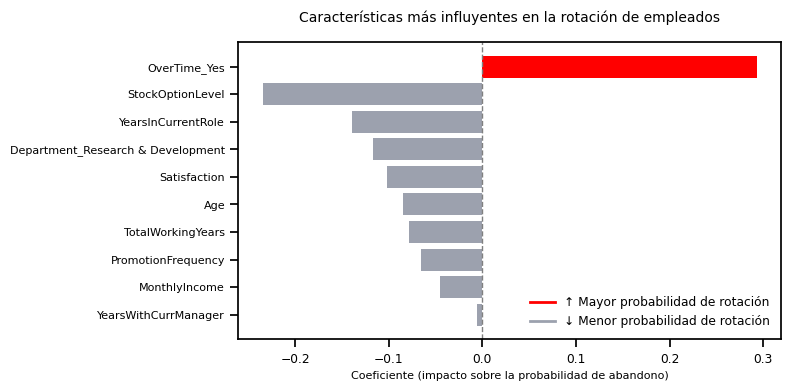

In [35]:
# mejor modelo del GridSearch
best_model = grid.best_estimator_

# Modelo de regresión logística
log_reg = best_model.named_steps['model']

# Nombres de las características transformadas por el preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

coefs = log_reg.coef_[0]

importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_value': np.abs(coefs)
})

# Limpieza de nombres de columnas- elimina prefijos num__ o cat__
importance['clean_feature'] = importance['feature'].str.replace(r'^[a-zA-Z_]+__', '', regex=True)

# Valor absoluto de la importancia en orden desc
importance = importance.sort_values('abs_value', ascending=False)

top_features = importance.head(10).copy()

# Color según signo del coeficiente
top_features['color'] = np.where(top_features['coefficient'] > 0, 'red', '#9CA1AE')

plt.figure(figsize=(8, 4))

bars = plt.barh(
    top_features['clean_feature'],
    top_features['coefficient'],
    color=top_features['color']
)

# Línea vertical de referencia
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Coeficiente (impacto sobre la probabilidad de abandono)', fontsize=8)
plt.title('Características más influyentes en la rotación de empleados', fontsize=10, pad=15)
plt.yticks(fontsize=8)
plt.gca().invert_yaxis()  # la variable más influyente arriba

plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=2, label='↑ Mayor probabilidad de rotación'),
    plt.Line2D([0], [0], color='#9CA1AE', lw=2, label='↓ Menor probabilidad de rotación')
], loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

En el gráfico se presentan las variables con mayor influencia sobre la probabilidad de deserción laboral. Las barras rojas representan los factores que incrementan el riesgo de renuncia, mientras que las azules indican aquellos que favorecen la permanencia. 

El modelo de Regresión Logística identificó principalmente factores asociados a la retención del personal, entre ellos la opción a acciones, la compensación económica y la satisfacción general. En contraste, la variable **OverTime_Yes** mostró un efecto negativo significativo sobre la probabilidad de permanencia, lo que sugiere que trabajar horas extra constituye el principal factor de riesgo de rotación, posiblemente debido a la fatiga o al desequilibrio entre la vida laboral y personal.

### 6.5 Enfoque de Ensemble Learning: **Stacking Classifier**

Se implementará un **StackingClassifier** con el fin de combinar las fortalezas de los modelos **LogisticRegression** y **GradientBoosting**, para mejorar el rendimiento predictivo. El entrenamiento del modelo ensemble se llevará a cabo siguiendo la misma canalización utilizada para los modelos individuales, garantizando consistencia en el preprocesamiento y la evaluación.

In [36]:
#Definición del StackingClassifier = LogisticRegression + GradientBoosting
base_estimators = [
    ('logreg', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42, 
                                  C= 0.01, penalty= 'l1', 
                                  solver= 'liblinear')),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# meta-model
meta_model = LogisticRegression(max_iter=5000,random_state=42, C= 0.01, penalty= 'l1', 
                                solver= 'liblinear')
pipe_stack = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('stack', StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_model,
        cv=5,                
        n_jobs=-1,
        passthrough=True     # permite que el meta-model vea también las features originales (x_train)
    ))
])
scores = cross_validate(
    pipe_stack,
    X_train, y_train,
    cv=cv,
    scoring=['roc_auc', 'precision', 'recall', 'f1'],
    n_jobs=1)

for metric in ['test_roc_auc', 'test_precision', 'test_recall', 'test_f1']:
    print(f"{metric}: {np.mean(scores[metric]):.3f} ± {np.std(scores[metric]):.3f}")

test_roc_auc: 0.817 ± 0.032
test_precision: 0.479 ± 0.065
test_recall: 0.636 ± 0.049
test_f1: 0.546 ± 0.059


Evaluación de la capacidad de generalización del modelo en el conjunto de prueba:

In [37]:
#Evaluación del modelo en el conjunto de prueba
pipe_stack.fit(X_train, y_train)
y_pred = pipe_stack.predict(X_test)
y_probs = pipe_stack.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, y_probs)

print("=== Clasificación (StackingClassifier) ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc:.3f}")

=== Clasificación (StackingClassifier) ===
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       255
           1       0.43      0.51      0.47        39

    accuracy                           0.85       294
   macro avg       0.68      0.71      0.69       294
weighted avg       0.86      0.85      0.85       294

ROC AUC: 0.767


**Interpretación de resultados:**

El modelo **StackingClassifier** logró un equilibrio entre precisión y recall, alcanzando una exactitud del 85 %. Detecta correctamente el 51 % de los empleados que renuncian (recall = 0.51) y mantiene una precisión del 43 % en la clase positiva. Es decir, reduce drásticamente los falsos positivos y mejora la capacidad de detección real de abandonos. El enfoque de ensamblado mejora la estabilidad del desempeño frente a los modelos individuales, logrando un balance mucho más útil para la toma de decisiones pues realiza predicciones más confiables lo que se traduce en menos intervenciones innecesarias.

En sintesís, el model identifica cerca de la mitad de los casos de rotación, conserva una buena capacidad general de clasificación y muestra comportamiento estable entre entrenamiento y prueba, sin indicios de sobreajuste. 

## 7. Conclusiones y recomendaciones

El análisis exploratorio permitió identificar factores relevantes asociados con la rotación de empleados, destacando que las variables relacionadas con las condiciones laborales: JobRole y OverTime, y MaritalStatus influyen en mayor proporción en la tasa de abandono. El análisis univariado permitió evidenciar que los empleados con menor satisfacción y estabilidad laboral tienden a abandonar la empresa con más frecuencia. Las correlaciones entre variables numéricas fueron, en general, bajas, lo que indica independencia entre factores individuales, aunque se observaron asociaciones notables entre la variable objetivo y aspectos categóricos como la realización de horas extras, el rol laboral y el estatus marital.

En la fase predictiva, el modelo de Regresión Logística, evaluado emdiante validación cruzada estratificada, presentó el mejor desempeño discriminando entre quienes permanecian o abandonaban la empresa con una ROC AUC de 0.84 y una sensibilidad en la detección de aquellos con mayor probabilidad de renunciar del 77% en el conjunto de prueba. Sin embargo, el modelo presentó una precisión baja (0.19) marcando muchos casos como en riesgo que realmente no se macharian. En cuanto a la importancia de características, el modelo identifico a la variable OverTime_Yes como el factor más influyente en la rotación de personal, posiblemente debido a la fatiga o al desequilibrio entre la vida laboral y personal. En contraste, factores como la opción a acciones, pertenercer al departamento de I+D y satisfacción general (laboral, ambiental), favorecen la permanencia laboral.

Posterior a la implementación  del StackingClassifier combinando Logistic Regression y Gradient Boosting, con el objetivo de alcanzar un rendimiento equilibrado en las predicciones, se alcanzó un ROC AUC de 0.817 ± 0.032, recall de 0.636 ± 0.049 y una precisión de 0.479 ± 0.065 durante el entrenamiento, frente a un ROC AUC de 0.766, recall de 0.51 y precisión de 0.43 en el conjunto de prueba. Aunque la precisión se mantiene moderada (≈0.43), el enfoue ensamblado representa una mejora respecto al modelo individual pues ofrece un  mejor balance entre sensibilidad y exactitud al reducir la intervenciones innecasarias. Este resultado se considera adecuado considerando los costos asociados a las estrategias de retención. 

En conclusión, el enfoque ensamblado se presenta como una herramienta útil en el análisis de la rotación de personal, permitiendo priorizar estrategias de retención y orientar las intervenciones de recursos humanos hacia los perfiles con mayor riesgo de abandonar la compañía. En este sentido, se recomienda fortalecer los planes de desarrollo profesional para roles técnicos y administrativos (recursos humanos - ventas) y diseñar politicas que mitiguen el trabajo durante horas extra. Asímismo, implementar encuestas de satisfacción periódicas para anticipar el riesgo de abandono en el personal.